# ArXiv Semantic Graph – Project Demo

This notebook demonstrates the main steps of our pipeline:

1. Exploratory Data Analysis (EDA)
2. Embeddings (Universal Sentence Encoder)
3. HNSW index for fast nearest neighbours
4. Distance histogram and global threshold τ
5. Semantic graph construction
6. Graph clustering (Louvain communities)
7. Semantic recommendation demo


## Section 0 - Imports and paths

In [2]:
from pathlib import Path
import sys

ROOT = Path("..").resolve()
SRC = ROOT / "src"

# Add src/ directory to PYTHONPATH
sys.path.append(str(SRC))

print("PYTHONPATH updated:", SRC)

# Now imports work like a real package:
from arxiv_semantic_graph import eda, embeddings, graph, graph_clustering, recommend

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

DATA_PATH = ROOT / "data" / "arxiv-metadata-oai-snapshot.json"
OUTPUTS = ROOT / "outputs"
OUTPUTS.mkdir(exist_ok=True)


PYTHONPATH updated: /home/zealot/DTU/Computational_Tools/src


## Section 1 - EDA

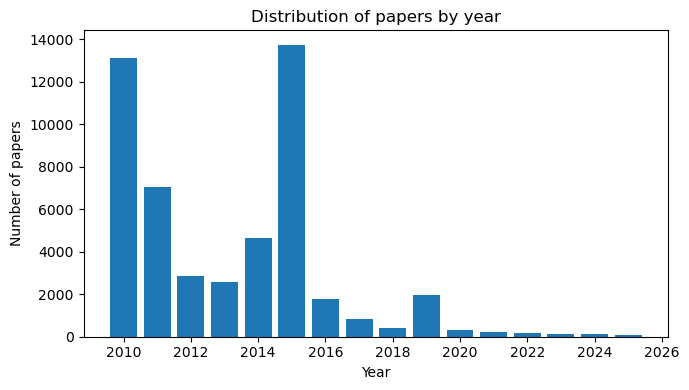

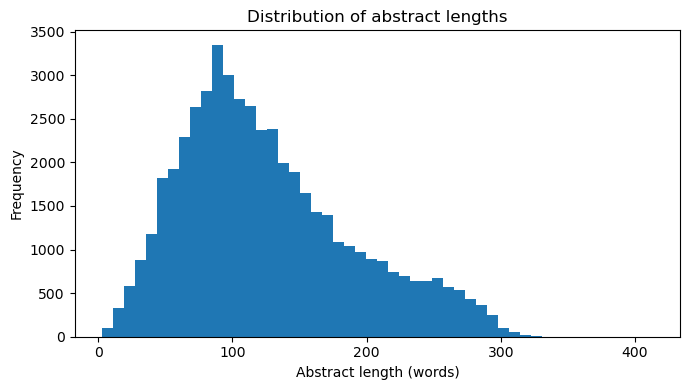

In [2]:
years, lengths = eda.load_eda_data(
    file_path=str(DATA_PATH),
    max_papers=50000,
    min_year=2010,
)

stats = eda.compute_eda_stats(years, lengths)

eda.plot_year_distribution(years, save_path=None, show=True)
eda.plot_length_distribution(lengths, save_path=None, show=True)

## Section 2 -Embeddings

In [24]:
import sys, tensorflow as tf
print(sys.executable)
print(tf.__version__)
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices("GPU"))


/home/zealot/micromamba/envs/arxivrec/bin/python
2.15.0
True
[]


In [5]:
DATA_PATH = Path("../data/arxiv-metadata-oai-snapshot.json")
EMB_DIR = Path("../outputs/embeddings")
EMB_DIR.mkdir(exist_ok=True)

total_embedded = embeddings.run_embeddings(
    file_path=str(DATA_PATH),
    out_dir=str(EMB_DIR),
    batch_size=64,
    shard_size=25000,
    min_year=2010,
    min_words=10,
    use_gpu=True,           # ← ENABLE GPU
    vram_mib=4096,          # ← OPTIONAL: cap GPU memory
    force_recompute=False,
)

print("Total embedded:", total_embedded)


[GPU] Config failed, falling back to CPU: Cannot set memory growth on device when virtual devices configured
[Embeddings] Reading from: ../data/arxiv-metadata-oai-snapshot.json
[Embeddings] Writing shards to: ../outputs/embeddings
[Embeddings] Filters: min_year=2010, min_words=10
[Embeddings] Batch size: 64, Shard size: 25000
[USE] Loading Universal Sentence Encoder...
[USE] Model loaded successfully
[Embeddings] Starting streaming and embedding...
[Shard 0] saved 25000 papers (total 25000)
[Shard 1] saved 25000 papers (total 50000)
[Shard 2] saved 25000 papers (total 75000)
[Shard 3] saved 25000 papers (total 100000)
[Shard 4] saved 25000 papers (total 125000)
[Shard 5] saved 25000 papers (total 150000)
[Shard 6] saved 25000 papers (total 175000)
[Shard 7] saved 25000 papers (total 200000)
[Shard 8] saved 25000 papers (total 225000)
[Shard 9] saved 25000 papers (total 250000)
[Shard 10] saved 25000 papers (total 275000)
[Shard 11] saved 25000 papers (total 300000)
[Shard 12] saved 250

## Section 3 - HNSW

In [15]:
import glob
from arxiv_semantic_graph.graph import load_shapes, build_or_load_index


# 3.1 – Locate embedding shards
emb_paths = sorted(glob.glob(str(EMB_DIR / "emb_*.npy")))
assert emb_paths, f"No emb_*.npy files found in {EMB_DIR}"

N, D = load_shapes(emb_paths)
print(f"[Info] Total vectors: {N:,} | Dimension: {D}")

# 3.2 – Build or load HNSW index
index = build_or_load_index(
    emb_paths=emb_paths,
    dim=D,
    out_dir=OUTPUTS / "hnsw",
    efc=200,   # ef_construction (controls construction quality vs speed)
    M=16,      # maximum number of connections per node
    threads=8,
)

# 3.3 – Quick sanity check: k-NN query for a random paper
import random
import numpy as np

random_id = random.randint(0, N - 1)

# Load the actual embedding for that paper (better than using a dummy vector)
offset = 0
query_vec = None
for p in emb_paths:
    arr = np.load(p, mmap_mode="r")
    n = arr.shape[0]
    if random_id < offset + n:
        query_vec = arr[random_id - offset].astype("float32")
        break
    offset += n

assert query_vec is not None, "Could not locate embedding for random_id"

labels, dists = index.knn_query(query_vec.reshape(1, -1), k=5)

print(f"[HNSW] Index is ready.")
print(f"[HNSW] Example query for id {random_id} returns {labels.shape[1]} neighbors.")
print("Neighbor IDs:", labels[0])
print("Distances:   ", dists[0])


[Info] Total vectors: 2,422,674 | Dimension: 512
[HNSW] Building index…
  Added 25000/2422674
  Added 50000/2422674
  Added 75000/2422674
  Added 100000/2422674
  Added 125000/2422674
  Added 150000/2422674
  Added 175000/2422674
  Added 200000/2422674
  Added 225000/2422674
  Added 250000/2422674
  Added 275000/2422674
  Added 300000/2422674
  Added 325000/2422674
  Added 350000/2422674
  Added 375000/2422674
  Added 400000/2422674
  Added 425000/2422674
  Added 450000/2422674
  Added 475000/2422674
  Added 500000/2422674
  Added 525000/2422674
  Added 550000/2422674
  Added 575000/2422674
  Added 600000/2422674
  Added 625000/2422674
  Added 650000/2422674
  Added 675000/2422674
  Added 700000/2422674
  Added 725000/2422674
  Added 750000/2422674
  Added 775000/2422674
  Added 800000/2422674
  Added 825000/2422674
  Added 850000/2422674
  Added 875000/2422674
  Added 900000/2422674
  Added 925000/2422674
  Added 950000/2422674
  Added 975000/2422674
  Added 1000000/2422674
  Added 10

## Section 4 — Distance histogram & τ

In [12]:
# ---------------------------
# Section 3 — HNSW Index
# ---------------------------

from pathlib import Path
import glob
import numpy as np
from arxiv_semantic_graph.graph import load_shapes, build_or_load_index

print("[Section 3] Building or loading HNSW index...")

# 3.1 Locate embedding shards
EMB_DIR = ROOT / "outputs" / "embeddings"
emb_paths = sorted(glob.glob(str(EMB_DIR / "emb_*.npy")))
assert emb_paths, f"No embedding shards found in: {EMB_DIR}"

# 3.2 Get total vectors (N) and dimensionality (D)
N, D = load_shapes(emb_paths)
print(f"[Info] Total vectors = {N:,} | Dimension = {D}")

# 3.3 Build or load HNSW index
index = build_or_load_index(
    emb_paths=emb_paths,
    dim=D,
    out_dir=OUTPUTS / "hnsw",
    efc=200,
    M=16,
    threads=8,
)

print("[Section 3] HNSW index ready.")
print()


[Section 3] Building or loading HNSW index...
[Info] Total vectors = 2,422,674 | Dimension = 512
[HNSW] Loaded existing index.
[Section 3] HNSW index ready.



In [ ]:
from arxiv_semantic_graph.graph import (
    compute_knn_distance_histogram,
    choose_tau_from_percentile,
)

print("[Section 4] Computing k-NN distance histogram...")

hist_result = compute_knn_distance_histogram(
    emb_dir=str(EMB_DIR),
    index=index,
    k=6,                      # 1 (self) + 5 neighbors
    out_dir=str(OUTPUTS / "eda")   # Stores plots & stats
)

hist_summary = hist_result["summary"]
hist_summary


[Section 4] Computing k-NN distance histogram...
[Histogram] Computing distance distributions with k=6…


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

bins = hist_result["bins"]
global_hist = hist_result["global_hist"]
centers = 0.5 * (bins[1:] + bins[:-1])

plt.figure(figsize=(10, 5))
plt.bar(centers, global_hist, width=(bins[1] - bins[0]), color="steelblue", edgecolor="black")
plt.xlabel("Cosine distance to nearest neighbors")
plt.ylabel("Frequency")
plt.title("Global k-NN Distance Distribution")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
# Define candidate p_keep values
pkeep_candidates = [0.05, 0.10, 0.15, 0.20, 0.25]

tau_candidates = []

for p in pkeep_candidates:
    tau = choose_tau_from_percentile(
        hist_result["bins"],
        hist_result["global_hist"],
        pkeep=p
    )
    tau_candidates.append((p, tau))

tau_candidates


In [ ]:
import pandas as pd

tau_df = pd.DataFrame(
    [{"p_keep": p, "tau": tau} for p, tau in tau_candidates]
)

tau_file = OUTPUTS / "tau_candidates.csv"
tau_df.to_csv(tau_file, index=False)

print("Saved τ candidates to:", tau_file)


tau_df


## Section 5 — Graph construction

In [ ]:
tau_file = OUTPUTS / "tau_candidates.csv"
tau_df.to_csv(tau_file, index=False)

print("Saved τ candidates to:", tau_file)


## Section 6 - Louvain communities

In [ ]:
tau_star = tau_candidates[1]
edge_path_star = [r["edge_path"] for r in results_tau if r["tau"] == tau_star][0]

CLUSTER_OUT = OUTPUTS / "clustering"
CLUSTER_OUT.mkdir(exist_ok=True)

louvain_result = graph_clustering.run_louvain(
    edge_path=edge_path_star,
    num_nodes=N,
    out_dir=str(CLUSTER_OUT),
)

## Section 7 - Recomendation demo

In [ ]:
meta = recommend.load_metadata(str(EMB_DIR))

recs = recommend.recommend_random(
    index=index,
    emb_dir=str(EMB_DIR),
    metadata=meta,
    k=5,
    tau=tau_star,
    louvain_labels=louvain_result["labels"],
)